In [1]:
import pandas as pd, requests, numpy as np
import urllib.request
import bar_chart_race as bcr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
##LOAD Town COVIDATA [MOH-IL]
url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=8a21d39d-91e3-40db-aca1-f73f7ab1df69&limit=150000'
json = requests.get(url).json()
df = pd.DataFrame(json['result']['records'])


In [3]:
##load town data [CBS-IL]
url='https://www.cbs.gov.il/he/publications/doclib/2019/ishuvim/bycode2019.xlsx'
cbs_town = pd.read_excel(url)


In [4]:
##lower case column name
df = df.rename(columns=lambda x:x.lower())

## use 10 instead of less than
df = df.replace('<15','10')

## cols data types
cols = ['city_code','cumulative_verified_cases',
       'cumulated_recovered', 'cumulated_deaths', 'cumulated_number_of_tests',
       'cumulated_number_of_diagnostic_tests']
for x in cols:
    df[x] = df[x].astype('int')
df['date']=pd.to_datetime(df.date)
# df.dtypes
# df.head()

In [5]:
## town_df
town_df = cbs_town[['סמל יישוב', 'סך הכל אוכלוסייה 2019']].rename(columns={'סמל יישוב' : 'city_code',
                                                                           'סך הכל אוכלוסייה 2019' : 'pop'})

##convert population na to 0
town_df['pop'] = town_df['pop'].fillna(0).astype('int')

##merge to main COVIDF
covidf = df.merge(town_df, on='city_code')

In [6]:
# covidf_town
covidf_town = covidf[['city_code','city_name','pop']].drop_duplicates().sort_values(by='pop', ascending=False).reset_index(drop=True)

# remove tribes (0 population)
tribes = covidf_town.loc[covidf_town['pop']==0,'city_name'].unique()## len == 10
covidf_town = covidf_town.loc[~covidf_town.city_name.isin(tribes)]
covidf_town['pop'] = covidf_town['pop'].astype('int')

##SET City_Type
## City >=100,000 ; Town >=10,0000; Village < 10,000
covidf_town['city_type'] = ['City' if x >=100000 else 'Town' if x >=10000 else 'Village' for x in covidf_town['pop']]
# covidf_town[['pop']].plot.hist(bins=10)

#norm coefficients
norm_by_x = lambda x: covidf_town['pop']/x
covidf_town = covidf_town.assign(norm100k=norm_by_x(10**5), norm10k=norm_by_x(10**4), norm1k=norm_by_x(10**4))

##add city type to main COVIDF
covidf = covidf.merge(covidf_town[['city_code','city_type', 'norm100k', 'norm10k', 'norm1k']], on='city_code', how='left')

# len(covidf_town) ##261

In [7]:
covidf.columns

Index(['_id', 'city_name', 'city_code', 'date', 'cumulative_verified_cases',
       'cumulated_recovered', 'cumulated_deaths', 'cumulated_number_of_tests',
       'cumulated_number_of_diagnostic_tests', 'pop', 'city_type', 'norm100k',
       'norm10k', 'norm1k'],
      dtype='object')

In [8]:
##TEST
# col = 'cumulated_deaths'; city_type ='Town'
covidf.loc[covidf.city_name=='ירושלים'].iloc[-1]

_id                                                   24738
city_name                                           ירושלים
city_code                                              3000
date                                    2020-10-13 00:00:00
cumulative_verified_cases                             41300
cumulated_recovered                                   35516
cumulated_deaths                                        241
cumulated_number_of_tests                            440280
cumulated_number_of_diagnostic_tests                 408420
pop                                                  936425
city_type                                              City
norm100k                                            9.36425
norm10k                                             93.6425
norm1k                                              93.6425
Name: 24954, dtype: object

In [9]:
##normalize column for city_type
def barChartDFandNameTotal(covidf=covidf, col='cumulated_deaths', city_type='City'):
    df_val = covidf.query("city_type == '{}'".format(city_type))
    value_name = '{}_total_{}'.format(city_type.lower(), col.replace('cumulated_',''))
    
    #revert city name (hebrew)
    df_val['city_name'] = df_val['city_name'].apply(lambda x:x[::-1])
    #WIDE format
    df_bar = df_val.pivot(index='date',columns='city_name', values=col)
    # #clean and remove all zeros
    df_bar.columns.name = ''
    df_bar = df_bar.loc[df_bar.apply(lambda x: x.sum(), axis=1) > 0]

    print(value_name)
    print("number of {}: {}".format(city_type, len(df_bar.columns)))
    
    return df_bar, value_name

# df_c = df_p.dropna(how='all').dropna(how='all', axis=1).bfill().ffill()

# df_c.head()


In [10]:
##normalize column for city_type
def barChartDFandNameNorm(covidf=covidf, col='cumulated_deaths', city_type='City'):
    df_val = covidf.query("city_type == '{}'".format(city_type))
    k_col = 'norm100k' if city_type == 'City' else 'norm10k' if city_type == 'Town' else 'norm1k'
    df_val= df_val.assign(value=df_val[col] / df_val[k_col])
    value_name = '{}_{}_per_{}'.format(city_type.lower(), col.replace('cumulated_',''),k_col.replace('norm',''))
    
    #revert city name (hebrew)
    df_val['city_name'] = df_val['city_name'].apply(lambda x:x[::-1])
    #WIDE format
    df_bar = df_val.pivot(index='date',columns='city_name', values='value')
    # #clean and remove all zeros
    df_bar.columns.name = ''
    df_bar = df_bar.loc[df_bar.apply(lambda x: x.sum(), axis=1) > 0]

    print(value_name)
    print("number of {}: {}".format(city_type, len(df_bar.columns)))
    
    return df_bar, value_name

# df_c = df_p.dropna(how='all').dropna(how='all', axis=1).bfill().ffill()

# df_c.head()


In [12]:
wnorm100k = (covidf_town.norm100k * covidf_town['pop']).sum() / covidf_town['pop'].sum()
wnorm100k

2.15675017420446

In [18]:
def barChartRaceCreator(df_bar, value_name, city_type, n_bars=16, wnorm100k=wnorm100k):
    title_name = lambda x: x.title().replace('_', ' ')
    total_title = value_name.title().replace('_',' ').replace('{} '.format(city_type), '')
    
    ##summary func
    if 'per' in value_name and city_type=='City':   
        sum_func = lambda v, r: {'x': .98, 'y': .13,
                                 's': '{}: {:,.0f} (TOTAL: {})'.format(total_title, v.nlargest(n_bars).sum(),
                                                                       int(np.round(v.nlargest(n_bars).sum()*wnorm100k))),
                                 'family':'Lato', 'ha': 'right', 'size': 10}
    else:
        sum_func = lambda v, r: {'x': .98, 'y': .13,
                                 's': '{}: {:,.0f}'.format(total_title, v.nlargest(n_bars).sum()),
                                 'family':'Lato', 'ha': 'right', 'size': 10}
    bcr.bar_chart_race(df_bar,
                   n_bars=n_bars,
                   figsize=(7,5),
                   filter_column_colors=True,
                   period_fmt='%B %d, %Y',
                   period_label={'x': .98, 'y': .2, 'ha': 'right', 'va': 'center',
                                 'family':'Lato','weight':'bold', 'size':14},
                   period_summary_func=sum_func,
                   filename='barace/{}.mp4'.format(value_name),
                    shared_fontdict={'family' : 'Open Sans Hebrew','weight':'normal'},
                   period_length=200,
                   title = 'COVID in Israel - {}'.format(title_name(value_name)),
                   title_size=11,
                   tick_label_size=10,
                   bar_label_size=11,
                   cmap='tab20')
    

In [19]:
##rcParams - mpl style
mpl.rcParams['font.serif'] = ['Lato']
mpl.rcParams['axes.titleweight'] ='bold'


In [20]:
# ###TEST
# df_bar, value_name = barChartDFandNameNorm(city_type='City')
# df_bar_test = df_bar.loc[df_bar.index.month.isin([4])]
# barChartRaceCreator(df_bar_test, value_name, city_type='City')



In [21]:
## CREATE NORM AND TOTAL BAR CHARTS for City, Village and Town - this may take sometime...
for city_type in ['City']:# ,'Town','Village']:
    print(city_type)
    df_bar, value_name = barChartDFandNameNorm(city_type=city_type)
    barChartRaceCreator(df_bar, value_name, city_type)
#     df_bar, value_name = barChartDFandNameTotal(city_type=city_type)
#     barChartRaceCreator(df_bar, value_name, city_type)


City
city_deaths_per_100k
number of City: 16


### Current Situation

In [20]:
latest_date = covidf.date.max()
print(latest_date)


2020-10-13 00:00:00


In [21]:
df_latest = covidf.loc[covidf.date==latest_date]
df_city = df_latest.loc[df_latest.city_type=='City']

In [22]:
df_city = df_city.assign(norm_death_100k=df_city.cumulated_deaths/df_city.norm100k)
df_city.sort_values(by='norm_death_100k',inplace=True)

In [23]:
df_city.head()

,_id,city_name,city_code,date,cumulative_verified_cases,cumulated_recovered,cumulated_deaths,cumulated_number_of_tests,cumulated_number_of_diagnostic_tests,pop,city_type,norm100k,norm10k,norm1k,norm_death_100k
10849,10416,בית שמש,2610,2020-10-13,7443,6205,10,54075,50311,124957,City,1.24957,12.4957,12.4957,8.002753
8245,7812,באר שבע,9000,2020-10-13,5531,4477,38,114651,110518,209687,City,2.09687,20.9687,20.9687,18.122249
46871,46655,פתח תקווה,7900,2020-10-13,7471,6187,49,120478,115260,247957,City,2.47957,24.7957,24.7957,19.761491
39710,39277,נתניה,7400,2020-10-13,6695,5345,45,99049,94996,221352,City,2.21352,22.1352,22.1352,20.329611
54249,53816,רחובות,8400,2020-10-13,4444,3639,34,63608,60950,143904,City,1.43904,14.3904,14.3904,23.626862
53381,52948,ראשון לציון,8300,2020-10-13,5260,4289,61,104411,100366,254384,City,2.54384,25.4384,25.4384,23.979496
29728,29295,כפר סבא,6900,2020-10-13,1538,1251,26,45996,44601,101431,City,1.01431,10.1431,10.1431,25.633189
24954,24738,ירושלים,3000,2020-10-13,41300,35516,241,440280,408420,936425,City,9.36425,93.6425,93.6425,25.736177
7377,7161,אשקלון,7100,2020-10-13,4127,3345,39,74907,71548,144072,City,1.44072,14.4072,14.4072,27.069798
58155,57939,תל אביב - יפו,5000,2020-10-13,10157,8268,125,207684,197041,460613,City,4.60613,46.0613,46.0613,27.137749


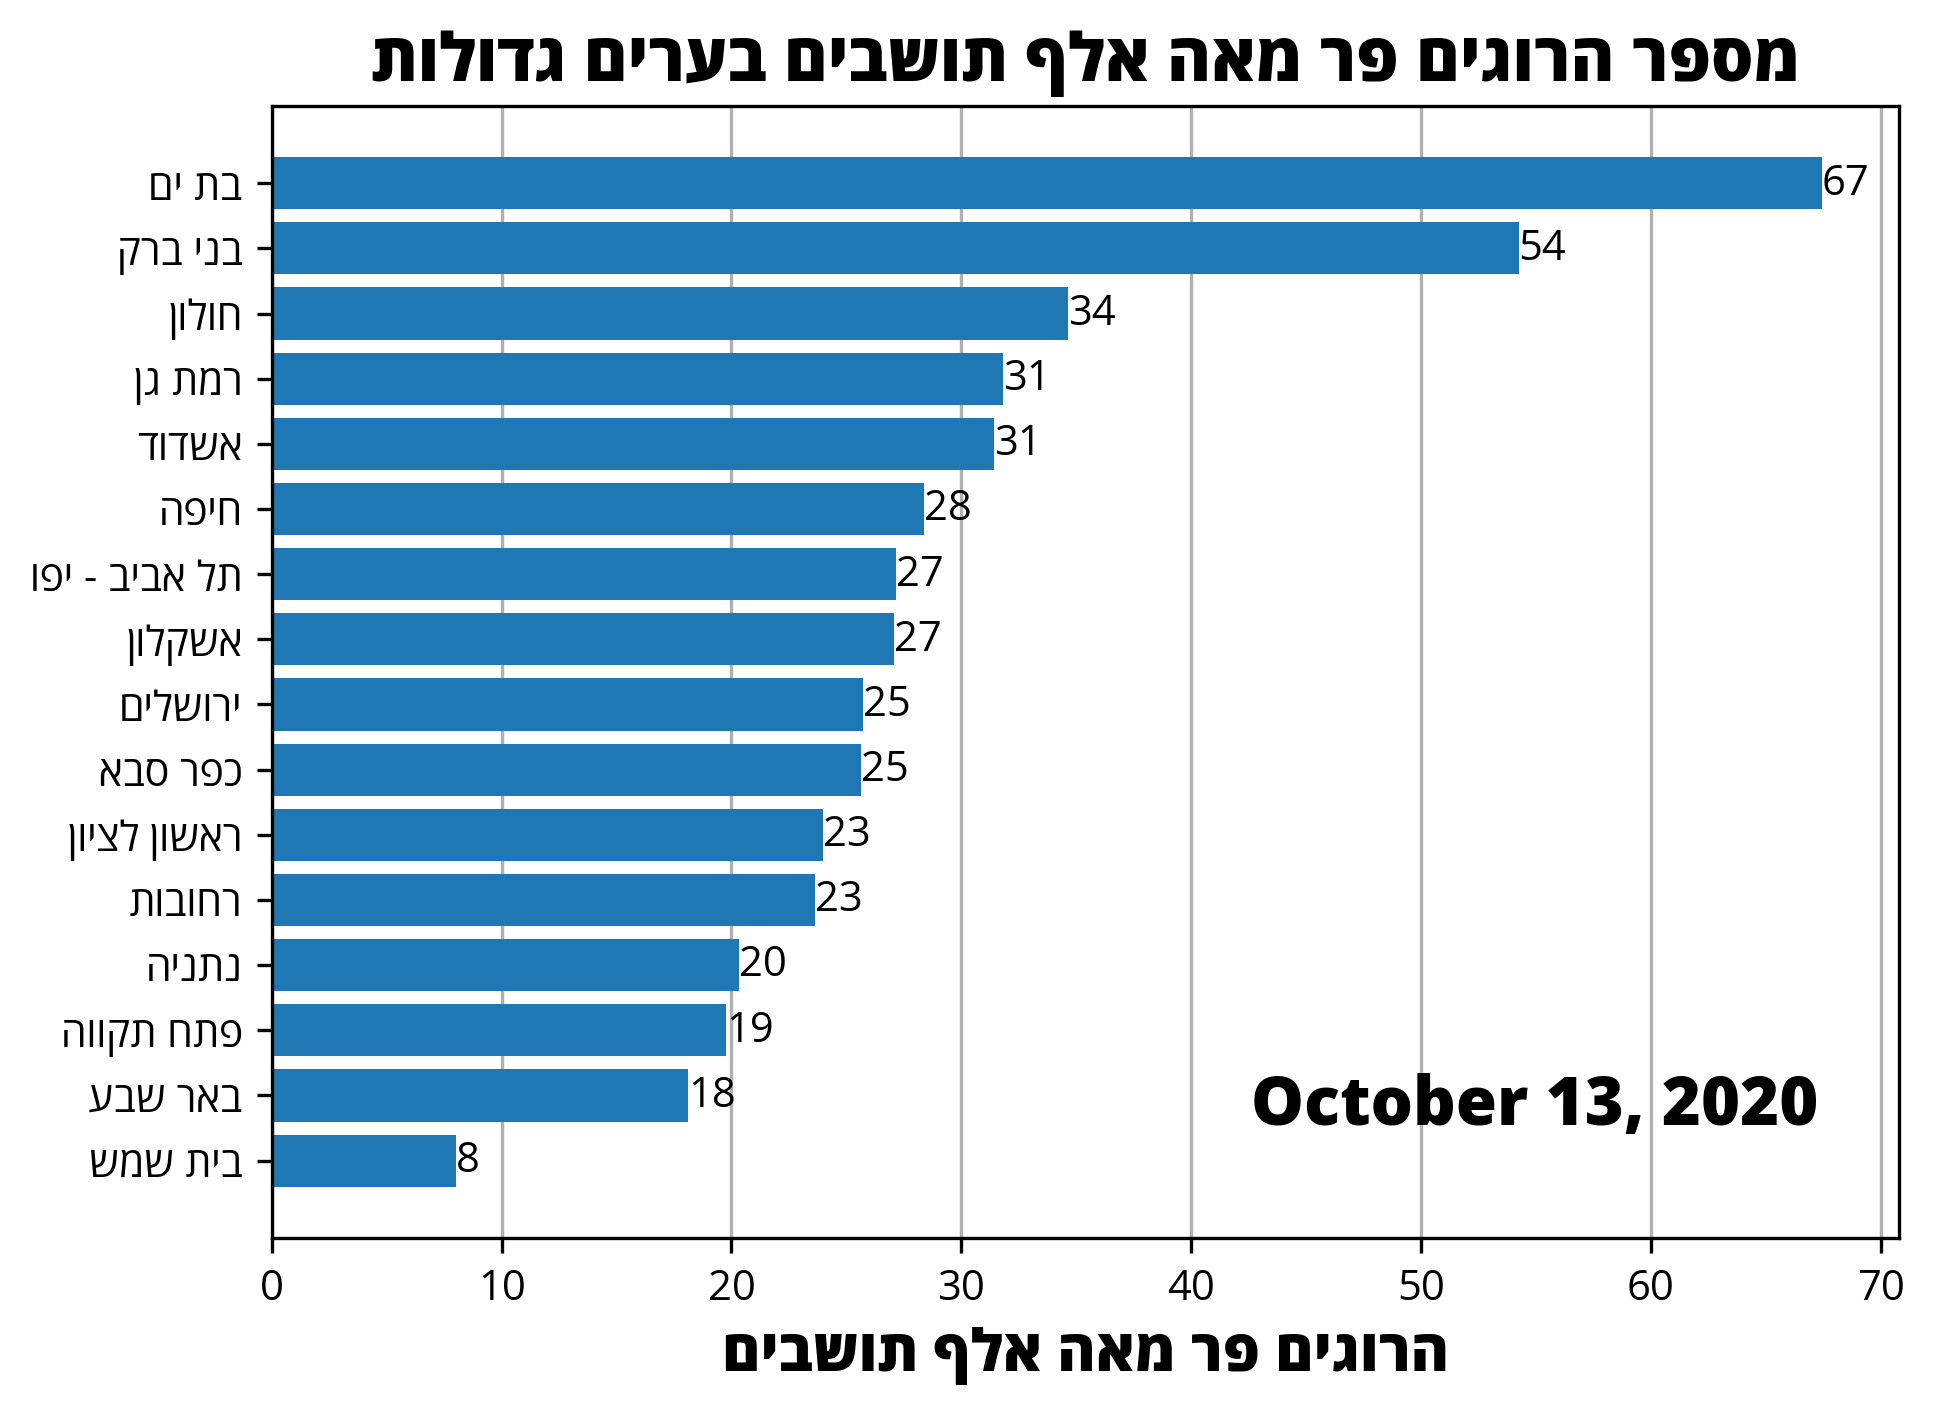

In [24]:
fig, ax = plt.subplots(figsize=(7,5), dpi=300)
ax.barh(df_city['city_name'].apply(lambda x:x[::-1]), df_city.norm_death_100k)
ax.set_xlabel('הרוגים פר מאה אלף תושבים'[::-1], weight='bold', fontsize=14)
plt.grid(True, axis='x')
ax.set_axisbelow(True)
ax.text(x=.95,y=.1,s=latest_date.strftime("%B %d, %Y"),weight='bold',fontsize=16,ha='right', transform=ax.transAxes)
ax.set_title("מספר הרוגים פר מאה אלף תושבים בערים גדולות"[::-1], weight='bold', fontsize=16)

rects = ax.patches

# Make some labels.
labels = ["label%d" % i for i in np.arange(len(rects))]

for i, rect in enumerate(rects):
    width = rect.get_width()
    reclabel = int(width)
    ax.text(width, i, reclabel,
            ha='left', va='center')

plt.show()
fig.savefig('graphs/town/latest_deaths_norm_city.jpg')
